In [5]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

overwrite_figures = True

In [6]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (256,256,128),
            baseline = (1540, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1540, rho=1000, sigma=30, scale=0.0001, label=0)
t1 = tissue.Tissue(name='t1', c=1540, rho=1000, sigma=0, scale=0.0001, label=1)
t2 = tissue.Tissue(name='t2', c=1540, rho=1000, sigma=15, scale=0.0001, label=2)
t3 = tissue.Tissue(name='t3', c=1540, rho=1000, sigma=30, scale=0.0001, label=3)
t4 = tissue.Tissue(name='t4', c=1540, rho=1000, sigma=45, scale=0.0001, label=4)
t5 = tissue.Tissue(name='t5', c=1540, rho=1000, sigma=60, scale=0.0001, label=5)

pos = 0.016
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

test_phantom.add_tissue_sphere((0,-2*pos,0), 8, t1)
test_phantom.add_tissue_sphere((0,-pos,0), 8, t2)
test_phantom.add_tissue_sphere((0,0,0), 8, t3)
test_phantom.add_tissue_sphere((0,pos,0), 8, t4)
test_phantom.add_tissue_sphere((0,2*pos,0), 8, t5)
test_phantom.add_tissue_sphere((2*pos,-2*pos,0), 12, t5)
test_phantom.add_tissue_sphere((2*pos,-pos,0), 12, t4)
test_phantom.add_tissue_sphere((2*pos,0,0), 12, t3)
test_phantom.add_tissue_sphere((2*pos,pos,0), 12, t2)
test_phantom.add_tissue_sphere((2*pos,2*pos,0), 12, t1)
    
test_phantom.set_default_tissue('t3')
test = test_phantom.get_complete()

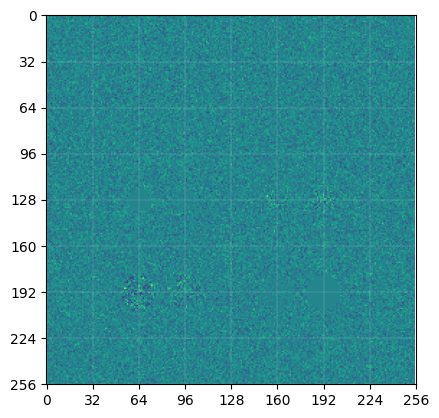

In [7]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [8]:
num_transducers = 3
transducers = [transducer.Planewave(max_frequency=2e6,
                                    elements = 256, 
                                    width = 40e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 5,
                                    imaging_ndims = 2,
                                    focus_elevation = 100e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

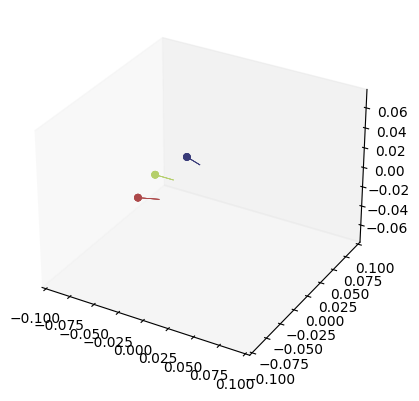

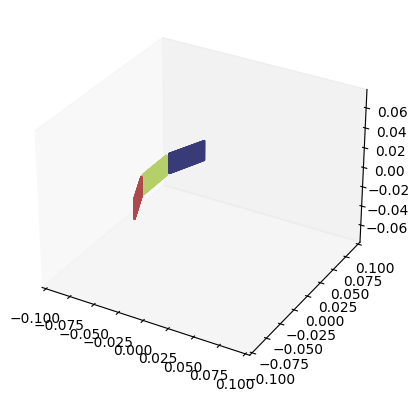

In [9]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([-np.pi/8,0,0], [-0.042,0.042,0]))
cont_transducer_set.assign_pose(1, geometry.Transform([0,0,0], [-0.05,0,0]))
cont_transducer_set.assign_pose(2, geometry.Transform([np.pi/8,0,0], [-0.042,-0.042,0]))

cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

In [10]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')

In [11]:
simprops = simulation.SimProperties(
                grid_size   = (110e-3,110e-3,30e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [12]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'synchronous_aperture_contrast',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = 'sequential_aperture_contrast',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

extended_experiment.save()
tar_experiment.save()

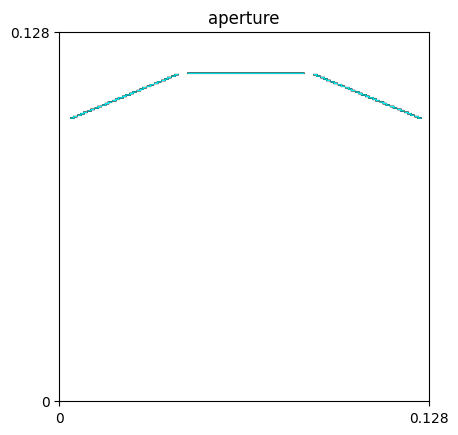

In [15]:
for i in range(52,78,1):
    gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), i])
    plt.gca().set_title('aperture')
    plt.gca().set_xticks([-1,255])
    plt.gca().set_xticklabels(['0','0.128'])
    plt.gca().set_yticks([-1,255])
    plt.gca().set_yticklabels(['0.128','0'])
    # plt.savefig('contrast_phantom.png', dpi=300, bbox_inches="tight")
    plt.savefig(f'video/contrast_phantom_{str(i).zfill(3)}.png', dpi=150)

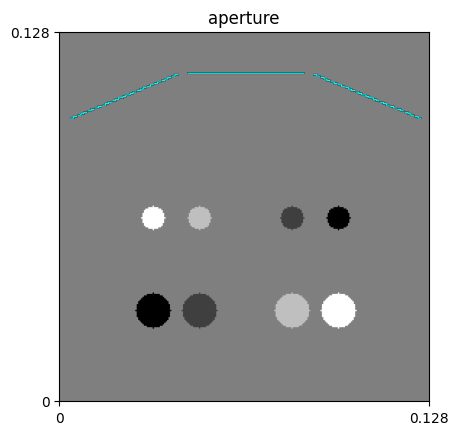

In [38]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,255])
plt.gca().set_xticklabels(['0','0.128'])
plt.gca().set_yticks([-1,255])
plt.gca().set_yticklabels(['0.128','0'])
plt.savefig('contrast_phantom.png', dpi=300, bbox_inches="tight")

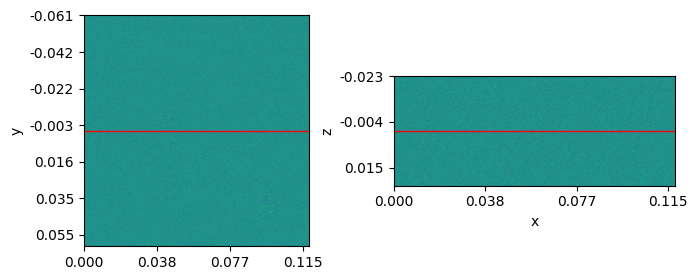

In [10]:
extended_experiment.plot_ray_path(0)

In [2]:
test_experiment = experiment.Experiment.load('sequential_aperture_contrast')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

running with 2 workers



KeyboardInterrupt: 

In [ ]:
test_experiment = experiment.Experiment.load('synchronous_aperture_contrast')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 3/3 [00:14<00:00,  4.89s/it]

running with 2 workers



preparation for sim    0 completed in 99.44 seconds
preparation for sim    1 completed in 98.36 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation             0 completed in 715.55 seconds
preparation for sim    2 completed in 98.33 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation             1 completed in 718.20 seconds
preparation for sim    3 completed in 98.57 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation             2 completed in 715.81 seconds
preparation for sim    4 completed in 97.53 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation             3 completed in 715.93 seconds
preparation for sim    5 completed in 98.39 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation      

# Reconstruction

In [3]:
test_experiment = experiment.Experiment.load('sequential_aperture_contrast')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


In [4]:
images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False, attenuation_factor=8)

100%|██████████| 15/15 [00:00<00:00, 308404.71it/s]


In [5]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//3], axis=0)/(len(images1)//3)
image1t2 = np.sum(images1[len(images1)//3:2*len(images1)//3], axis=0)/(len(images1)//3)
image1t3 = np.sum(images1[2*len(images1)//3:], axis=0)/(len(images1)//3)


In [6]:
from scipy.interpolate import NearestNDInterpolator
sensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensor.shape[0])):
    for j in range(sensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensor[i,j,:].sum(axis=-1))
X = np.linspace(0, sensor.shape[0], image1.shape[0])
Y = np.linspace(0, sensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,114:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:114] = 0
sensor_mask2[:,228:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:228] = 0

100%|██████████| 256/256 [00:00<00:00, 2430.67it/s]


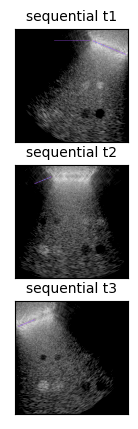

In [7]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image1t1 / np.amax(image1t1))
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray', vmin=-25, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
# CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[0].set_title('sequential t1', fontsize=10)

psf = 20 * np.log10(image1t2 / np.amax(image1t2))
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray', vmin=-25, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
# CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[1].set_title('sequential t2', fontsize=10)

psf = 20 * np.log10(image1t3 / np.amax(image1t3))
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray', vmin=-25, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
# CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[2].set_title('sequential t3', fontsize=10)

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_individual_contrast.png', dpi=300, bbox_inches="tight")

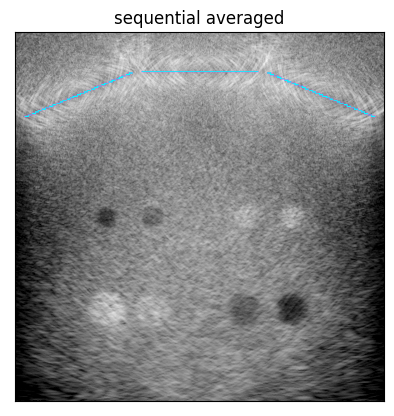

In [8]:
psf = 20 * np.log10(image1 / np.max(image1))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-25, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
# CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-20,-10])

ax.set_title('sequential averaged')

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_contrast.png', dpi=300, bbox_inches="tight")

In [9]:
test_experiment = experiment.Experiment.load('synchronous_aperture_contrast')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


In [10]:
images2 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False, attenuation_factor=12)

100%|██████████| 15/15 [00:00<00:00, 303935.07it/s]


preparation for sim    0 completed in 105.85 seconds
preparation for sim    1 completed in 105.69 seconds
prep worker has been inactive for 5.0 minutes
simulation             0 completed in 435.26 seconds
preparation for sim    2 completed in 103.70 seconds
prep worker has been inactive for 5.0 minutes
simulation             1 completed in 432.86 seconds
preparation for sim    3 completed in 103.30 seconds
prep worker has been inactive for 5.0 minutes
simulation             2 completed in 432.48 seconds
preparation for sim    4 completed in 104.13 seconds
prep worker has been inactive for 5.0 minutes
simulation             3 completed in 432.93 seconds
preparation for sim    5 completed in 104.89 seconds
prep worker has been inactive for 5.0 minutes
simulation             4 completed in 432.62 seconds
preparation for sim    6 completed in 105.57 seconds
prep worker has been inactive for 5.0 minutes
simulation             5 completed in 432.90 seconds
preparation for sim    7 completed 

In [11]:
image2 = np.sum(images2, axis=0)/len(images2)
image2t1 = np.sum(images2[:len(images2)//3], axis=0)/(len(images2)//3)
image2t2 = np.sum(images2[len(images2)//3:2*len(images2)//3], axis=0)/(len(images2)//3)
image2t3 = np.sum(images2[2*len(images2)//3:], axis=0)/(len(images2)//3)


In [12]:
from scipy.interpolate import NearestNDInterpolator
sensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensor.shape[0])):
    for j in range(sensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensor[i,j,:].sum(axis=-1))
X = np.linspace(0, sensor.shape[0], image1.shape[0])
Y = np.linspace(0, sensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,114:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:114] = 0
sensor_mask2[:,228:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:228] = 0

100%|██████████| 256/256 [00:00<00:00, 2435.65it/s]


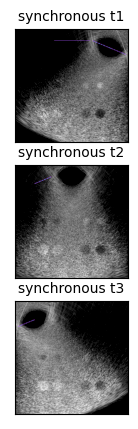

In [13]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image2t1 / np.max(image2t1))
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray', vmin=-25, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
# CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[0].set_title('synchronous t1', fontsize=10)

psf = 20 * np.log10(image2t2 / np.max(image2t2))
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray', vmin=-25, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
# CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[1].set_title('synchronous t2', fontsize=10)

psf = 20 * np.log10(image2t3 / np.max(image2t3))
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray', vmin=-25, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
# CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[2].set_title('synchronous t3', fontsize=10)

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
if overwrite_figures:
    plt.savefig('synchronous_aperture_individual_contrast.png', dpi=300, bbox_inches="tight")

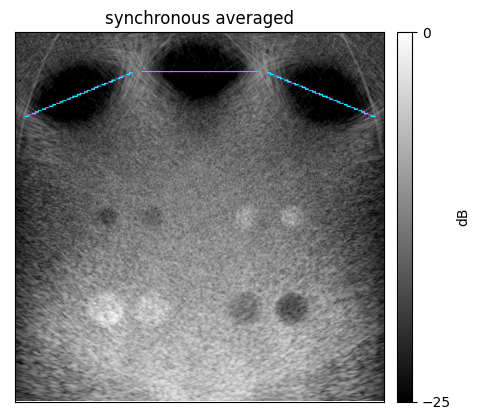

In [21]:
psf = 20 * np.log10(image2 / np.max(image2))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-25, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
# CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-20,-10])

ax.set_title('synchronous averaged')

plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-25,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig('synchronous_aperture_contrast.png', dpi=300, bbox_inches="tight")

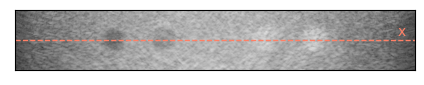

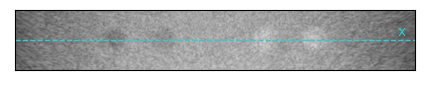

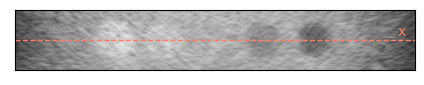

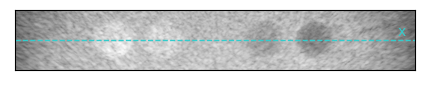

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
psf = 20 * np.log10(image1 / np.max(image1))
image = psf[285:385,:,psf.shape[2]//2]
plt.imshow(image, cmap='gray', vmin=-35, vmax=0)
plt.axhline(y=50, color=[1,0.5,0.4], linewidth=1, linestyle='--')
plt.text(635,43,'x', color=[1,0.5,0.4])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig('contrast_near_sequential.png', dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(1,1, figsize=(4,2))
psf = 20 * np.log10(image2 / np.max(image2))
image = psf[285:385,:,psf.shape[2]//2]
plt.imshow(image, cmap='gray', vmin=-35, vmax=0)
plt.axhline(y=50, color=[0.2,0.8,0.8], linewidth=1, linestyle='--')
plt.text(635,43,'x', color=[0.2,0.8,0.8])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig('contrast_near_synchronous.png', dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(1,1, figsize=(4,2))
psf = 20 * np.log10(image1 / np.max(image1))
image = psf[450:550,:,psf.shape[2]//2]
plt.imshow(image, cmap='gray', vmin=-35, vmax=0)
plt.axhline(y=50, color=[1,0.5,0.4], linewidth=1, linestyle='--')
plt.text(635,43,'x', color=[1,0.5,0.4])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig('contrast_far_sequential.png', dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(1,1, figsize=(4,2))
psf = 20 * np.log10(image2 / np.max(image2))
image = psf[450:550,:,psf.shape[2]//2]
plt.imshow(image, cmap='gray', vmin=-35, vmax=0)
plt.axhline(y=50, color=[0.2,0.8,0.8], linewidth=1, linestyle='--')
plt.text(635,43,'x', color=[0.2,0.8,0.8])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig('contrast_far_synchronous.png', dpi=300, bbox_inches="tight")

In [16]:
res_horz_indices1 = np.array([-73, -94, -31, -52, 73, 94, 31, 52])*2 + 331 - 100
res_horz_indices2 = np.array([-68, -99, -26, -57, 68, 99, 26, 57])*2 + 331 - 100

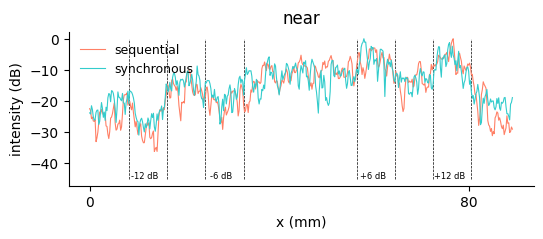

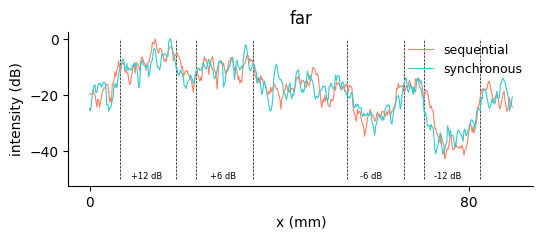

In [28]:
# near contrast horizontal
fig, ax = plt.subplots(1,1, figsize=(6,2))
index = 332
for xc in res_horz_indices1:
    ax.vlines(x=xc, ymin=-45,ymax=0, linewidth=0.5, color='k', linestyle='--')
ax.plot(20*np.log(image1[index,100:-100] / np.max(image1[index,100:-100])), linewidth = 0.8, c = [1,0.5,0.4], label='sequential')
ax.plot(20*np.log(image2[index,100:-100] / np.max(image2[index,100:-100])), linewidth = 0.8, c=[0.2,0.8,0.8], label='synchronous')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('intensity (dB)')
ax.set_xticks([0,416]) # 416 / 665 * 256 * 0.5
ax.set_xticklabels(['0','80'])
ax.set_xlabel('x (mm)')
ax.text(45,-45,'-12 dB', color='k', fontsize=6)
ax.text(132,-45,'-6 dB', color='k', fontsize=6)
ax.text(297,-45,'+6 dB', color='k', fontsize=6)
ax.text(378,-45,'+12 dB', color='k', fontsize=6)
ax.set_title('near')
ax.legend(frameon=False, loc='upper left', fontsize=9)
plt.savefig('contrast_near_horizontal_psf.png', dpi=300, bbox_inches="tight")


# far contrast horizontal
fig, ax = plt.subplots(1,1, figsize=(6,2))
index = 499
for xc in res_horz_indices2:
    ax.vlines(x=xc, ymin=-50,ymax=0, linewidth=0.5, color='k', linestyle='--')
ax.plot(20*np.log(image1[index,100:-100] / np.max(image1[index,100:-100])), linewidth = 0.8, c = [1,0.5,0.4], label='sequential')
ax.plot(20*np.log(image2[index,100:-100] / np.max(image2[index,100:-100])), linewidth = 0.8, c=[0.2,0.8,0.8], label='synchronous')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('intensity (dB)')
ax.set_xticks([0,416]) # 416 / 665 * 256 * 0.5
ax.set_xticklabels(['0','80'])
ax.set_xlabel('x (mm)')
ax.text(45,-50,'+12 dB', color='k', fontsize=6)
ax.text(132,-50,'+6 dB', color='k', fontsize=6)
ax.text(297,-50,'-6 dB', color='k', fontsize=6)
ax.text(378,-50,'-12 dB', color='k', fontsize=6)
ax.set_title('far')
ax.legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig('contrast_far_horizontal_psf.png', dpi=300, bbox_inches="tight")

In [ ]:
# 28 / 256 * 665
# 36 / 256 * 665
# 12 / 256 * 665
20 / 256 * 665

51.953125

In [ ]:
res_horz_indices = np.array([-73, -94, -31, -52, 73, 94, 31, 52])*2 + 332